## RNN Implementation

#### Temporary, for convenience

DECISIONS:
1. Calculate the drawdown and assign days with drawdown in the 99.5% quantile as crash (i.e. label=1). 
2. The target is shift 3 days to make the problem as "Predict if there will be a market crash 3 days later".



To-do: 
- More Plots?
- Add data
- more hyperparameter search
- better accuracy



### Data and imports   

#### Imports

In [ ]:
import numpy as np
import yfinance as yf # to get our data


from sklearn.preprocessing import MinMaxScaler # to normalize our classes
from sklearn.model_selection import train_test_split # from tutorial code
from sklearn.metrics import accuracy_score, confusion_matrix # needed for plotting

from tensorflow.keras.models import Sequential # sequential model for RNN
from tensorflow.keras.layers import Dense, LSTM # layers dense and long short term memory for RNN

import matplotlib.pyplot as plt # for plotting

import warnings
warnings.filterwarnings("ignore")

#### Get Data from Yahoo Finance

In [2]:
dfs = {} # Store all the data for our tickers, even though for now its just SP500
tickers = ['^GSPC',] # Ticker (identifier) for the SP500, which is arguably the most influential, we start with just this

# Got this code from https://www.kaggle.com/code/xxxxyyyy80008/predict-stock-market-crashes 
for ticker in tickers:
    cur_data = yf.Ticker(ticker)
    hist = cur_data.history(period="max")
    print(ticker, cur_data.info['shortName'], ticker, hist.shape, hist.index.min(), hist.index.max())
    dfs[ticker] = hist

^GSPC S&P 500 ^GSPC (24351, 7) 1927-12-30 00:00:00-05:00 2024-12-06 00:00:00-05:00


### Database and Preprocessing

#### Hyperparameters 

In [3]:
SEQUENCE_LENGTH = 15 # how large our window is
TEST_SIZE = 0.2
EPOCHS = 20
BATCH_SIZE = 20
SHIFT_DAYS = 3 # how far ahead we want to predict market crashes

#### Database creation

In [4]:
# Calculates how much the price has gone down from its highest point, labeling those with a 0.005 quantile as crashes as per directive 1
# NOTE: got help from chatgpt for this function to find .pct_change, .cummax and .quantile
def calculate_drawdown_and_label(data, quantile_threshold=0.005):

    data['daily_return'] = data['Close'].pct_change()

    data['drawdown'] = data['Close'] / data['Close'].cummax() - 1

    crash_threshold = data['drawdown'].quantile(quantile_threshold)

    data['crash_label'] = (data['drawdown'] < crash_threshold).astype(int)

    return data

## Make the data we targetted the target (nice), we try to predict the market crashes 3 days in advance so shift_days = 3
def prepare_target(data, shift_days=3):
    data['target'] = (data['crash_label']).astype(int).shift(-shift_days) # complicated line that basically takes our data with crash label, turns the bools into an int, then shift the values by 3 days to predict in advance, since we want to predict 3 days in advance
    return data

# prep the data
for ticker, data in dfs.items():
    data = calculate_drawdown_and_label(data) # get the drawdown for our data
    data = prepare_target(data, SHIFT_DAYS)
    dfs[ticker] = data


# Database done


#### Preprocessing

In [5]:
# Prepare data for RNN
def preprocess_data_for_rnn(data, sequence_length=15): # data is our data we

    scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize our features between 0 and 1 to make sure its all the same, since prices and dropdown are very much not all on scale.
    scaled_data = scaler.fit_transform(data[['Close', 'daily_return', 'drawdown']].dropna()) # our simple features we defined before + the ones from hist, scale them and create. .dropna removes the rows that have features which are nan i.e. rows with missing features

    X = []
    y = []

    for i in range(len(scaled_data) - sequence_length): # process data by sequences of days to learn. This is a window, so we go from one day to the next. for example, if we have day 1 to day 15 on iteration i, at iteration i + 1 we have day 2 to 16. this window is a single datapoint within a single minibatch.
        days = scaled_data[i:i+sequence_length] # get the sequence of 15 days
        X.append(days) # add to x the data as sequences of 15 days
        y.append(data['target'].iloc[i + sequence_length]) # this is the target. It adds the value of the next sequence as the target, so we can predict future crashes

    X = np.array(X) # turn into array for processing
    y = np.array(y)
     
    
    y = y[~np.isnan(y)]  # remove nan of the last few data points, since we shift by 3 days the last few points. i.e. for day 1, the target is day 4 for three days. so at the end of the seuquence wed get 3 empty datapoints. 
    X = X[:len(y)]  # cut those data points which had no y, i.e. the last few days
    return X, y, scaler # return the scaler function to make sure when we process the test data and validation data, we can process the data before feeding it into our model




# now we process our data, here we do as if we had multiple tickers, in case we add more later
sequence_length = SEQUENCE_LENGTH # hyperparameter for the length of the window. 15 is completely arbirtrary here, need to adjust to get better or worst results.
X = {} # data of all the tickers
y = {} # labels of all the tickers
scalers = {} # scalers of all the tickers
for ticker, data in dfs.items(): #iterate through each ticker, datapoint and the dataframes (dfs) we got from yf, and preprocess them then add them to the dictionnary
    X[ticker], y[ticker], scalers[ticker] = preprocess_data_for_rnn(data, sequence_length=sequence_length) 

# Combine data from all our tickers, joining them on axis 0 i.e. we want to concatenate all the rows together
X_all = np.concatenate([X[ticker] for ticker in X], axis=0)
y_all = np.concatenate([y[ticker] for ticker in y], axis=0) # same thing for labels

# give 20% as test size, 80% for our training data. this functino was found in the tutorial ipynb
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=TEST_SIZE, random_state=42)

### RNN

#### Model

In [6]:
# RNN model from keras. When we use another model (ARIMA or TRANSFORMERS) we can change just this!
# NOTE: chtgpt helped me find the return_sequences parameter and input_shape parameters. it also helped me find the model.compile names of the specific functions (is it binary_cross_entropy or binary_crossentropy)
def rnn_model(input): # by giv
    model = Sequential() # choose the RNN (i.e. sequential) so we can stack models
    model.add(LSTM(units=50, return_sequences=True, input_shape=input)) # first lstm layer with 50 nodes (arbitrary), we return sequences not the final output since were passing it to another lstm layer
    model.add(LSTM(units=50)) # second LSTM layer, this time we do return the final output
    model.add(Dense(units=1, activation='sigmoid'))  #dense layer with 1 node to classify binary. because were classifying binarily whether theres a crash, then we use sigmoid to just classify if thres a crash or not
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compile our model with an adam optimizer to adjust our learning rate when were getting closer.. might need to try sgd. binary cross entropy since were binary. accuracy to track during trainign and testing.
    return model


#### Training

In [ ]:
# NOTE: Train the model. chatgpt helped me for the input_shape
input_shape = (X_train.shape[1], X_train.shape[2]) # recall X_train is (batch_size, sequence_length, 3 (for 3 features for now)), here we give the batch size and the sequence length
rnn = rnn_model(input_shape) # build our model with our function from before

rnn.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test)) # train our model. relatively large batch size considering we dont have much data, but im getting pretty good accuracy. we use our test data for validation, arguably not great but were not using for early stopping so I guess its ok

Epoch 1/20


C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9881 - loss: 0.0571 - val_accuracy: 0.9967 - val_loss: 0.0078
Epoch 2/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9972 - loss: 0.0090 - val_accuracy: 0.9975 - val_loss: 0.0069
Epoch 3/20
610/974 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9976 - loss: 0.0070

### Plotting and Metrics

#### Metrics and final accuracy

In [ ]:
##### GET ACCURACY AND CONFUSION MATRIX #####
predictions_as_probabilities = rnn.predict(X_test)
predictions_as_classes = (predictions_as_probabilities > 0.5).astype(int) # make our predictions binary, a simple scaler that puts values higher than 0.5 to 1 and lower 0. astypeint to return 0 and 1 instead of true false array.
accuracy = accuracy_score(y_test, predictions_as_classes) # calculate our accuracy

confusion_matrix_var = confusion_matrix(y_test, predictions_as_classes) # plot the confusion matrix
#############################################


### FINAL ACCURACY
print(f"Test Accuracy: {accuracy}") # print our final accuracy

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.9983559391697493


#### Plotting

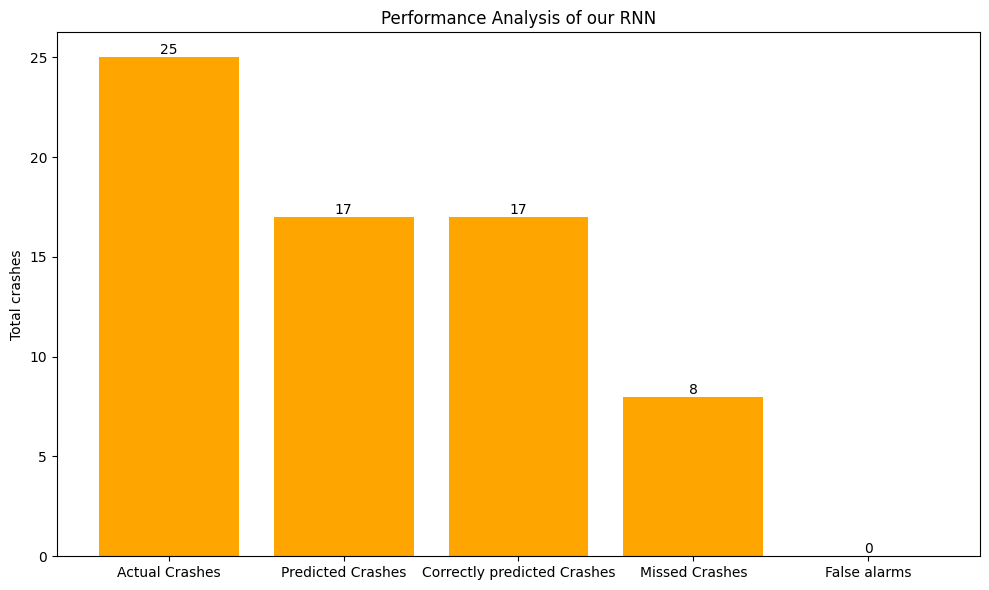

In [ ]:
real_crashes = int(sum(y_test == 1)) # crashes in our test data
predicted_crashes = int((predictions_as_classes == 1).sum()) # crashes are 1 in our predictions
predicted_correctly = int(confusion_matrix_var[1, 1])  # tp in our confusion matrix
missed_crashes = int(confusion_matrix_var[1, 0])  # fn in our confusion matrix
predicted_when_there_wasnt = int(confusion_matrix_var[0, 1])  # fp in our confusion matrix

categories = [
    "Actual Crashes",
    "Predicted Crashes",
    "Correctly predicted Crashes",
    "Missed Crashes",
    "False alarms"
]
values = [
    real_crashes,
    predicted_crashes,
    predicted_correctly,
    missed_crashes,
    predicted_when_there_wasnt,
]


plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color='orange')
plt.title("Performance Analysis of our RNN")
plt.ylabel("Total crashes")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
